In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%config IPCompleter.greedy = True

In [ ]:
cd /content/drive/My Drive/Project/

/content/drive/My Drive/Project


In [ ]:
import glob
import cv2
import numpy as np
import tensorflow as tf
import keras

Using TensorFlow backend.


In [ ]:
patch_size, stride = 40, 10
aug_times = 1
scales = [1, 0.9, 0.8, 0.7]
batch_size = 128


def show(x,title=None,cbar=False,figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x,interpolation='nearest',cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()

In [ ]:
def data_aug(img, mode=0):

    if mode == 0:
        return img
    elif mode == 1:
        return np.flipud(img)
    elif mode == 2:
        return np.rot90(img)
    elif mode == 3:
        return np.flipud(np.rot90(img))
    elif mode == 4:
        return np.rot90(img, k=2)
    elif mode == 5:
        return np.flipud(np.rot90(img, k=2))
    elif mode == 6:
        return np.rot90(img, k=3)
    elif mode == 7:
        return np.flipud(np.rot90(img, k=3))

In [ ]:
def gen_patches(file_name):

    # read image
    img = cv2.imread(file_name, 0)  # gray scale
    h, w = img.shape
    patches = []
    for s in scales:
        h_scaled, w_scaled = int(h*s),int(w*s)
        img_scaled = cv2.resize(img, (h_scaled,w_scaled), interpolation=cv2.INTER_CUBIC)
        # extract patches
        for i in range(0, h_scaled-patch_size+1, stride):
            for j in range(0, w_scaled-patch_size+1, stride):
                x = img_scaled[i:i+patch_size, j:j+patch_size]
                #patches.append(x)        
                # data aug
                for k in range(0, aug_times):
                    x_aug = data_aug(x, mode=np.random.randint(0,8))
                    patches.append(x_aug)
                
    return patches

In [ ]:
def datagenerator(data_dir='/content/drive/My Drive/Project/Dataset/Train400',verbose=False):
    
    file_list = glob.glob(data_dir+'/*.png')  # get name list of all .png files
    print(file_list)
    # initialize
    data = []
    # generate patches
    for i in range(len(file_list)):
        patch = gen_patches(file_list[i])
        data.append(patch)
        if verbose:
            print(str(i+1)+'/'+ str(len(file_list)) + ' is done ^_^')
    data = np.array(data, dtype='uint8')
    print(data.shape,"Before Reshape")
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],1))
    print(data.shape,"After Reshape_1")
    discard_n = len(data)-len(data)//batch_size*batch_size;
    data = np.delete(data,range(discard_n),axis = 0)
    print(data.shape,"After Reshape_2")
    print('^_^-training data finished-^_^')
    return data
    
if __name__ == '__main__':   

    data = datagenerator(data_dir='/content/drive/My Drive/Project/Dataset/Train400')
    

#    print('Shape of result = ' + str(res.shape))
#    print('Saving data...')
#    if not os.path.exists(save_dir):
#            os.mkdir(save_dir)
#    np.save(save_dir+'clean_patches.npy', res)
#    print('Done.')  

['/content/drive/My Drive/Project/Dataset/Train400/test_002.png', '/content/drive/My Drive/Project/Dataset/Train400/test_005.png', '/content/drive/My Drive/Project/Dataset/Train400/test_004.png', '/content/drive/My Drive/Project/Dataset/Train400/test_001.png', '/content/drive/My Drive/Project/Dataset/Train400/test_003.png', '/content/drive/My Drive/Project/Dataset/Train400/test_006.png', '/content/drive/My Drive/Project/Dataset/Train400/test_010.png', '/content/drive/My Drive/Project/Dataset/Train400/test_007.png', '/content/drive/My Drive/Project/Dataset/Train400/test_009.png', '/content/drive/My Drive/Project/Dataset/Train400/test_008.png', '/content/drive/My Drive/Project/Dataset/Train400/test_011.png', '/content/drive/My Drive/Project/Dataset/Train400/test_015.png', '/content/drive/My Drive/Project/Dataset/Train400/test_013.png', '/content/drive/My Drive/Project/Dataset/Train400/test_012.png', '/content/drive/My Drive/Project/Dataset/Train400/test_016.png', '/content/drive/My Drive

In [ ]:
def tf_ssim(img1, img2, cs_map=False, mean_metric=True, size=11, sigma=1.5):
    window = _tf_fspecial_gauss(size, sigma) # window shape [size, size]
    K1 = 0.01
    K2 = 0.03
    L = 1  # depth of image (255 in case the image has a differnt scale)
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    mu1 = tf.nn.conv2d(img1, window, strides=[1,1,1,1], padding='VALID')
    mu2 = tf.nn.conv2d(img2, window, strides=[1,1,1,1],padding='VALID')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = tf.nn.conv2d(img1*img1, window, strides=[1,1,1,1],padding='VALID') - mu1_sq
    sigma2_sq = tf.nn.conv2d(img2*img2, window, strides=[1,1,1,1],padding='VALID') - mu2_sq
    sigma12 = tf.nn.conv2d(img1*img2, window, strides=[1,1,1,1],padding='VALID') - mu1_mu2
    if cs_map:
        value = (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2)),
                (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        value = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value

def tf_ms_ssim(img1, img2, mean_metric=True, level=5):
    weight = tf.constant([0.0448, 0.2856, 0.3001, 0.2363, 0.1333], dtype=tf.float32)
    mssim = []
    mcs = []
    for l in range(level):
        ssim_map, cs_map = tf_ssim(img1, img2, cs_map=True, mean_metric=False)
        mssim.append(tf.reduce_mean(ssim_map))
        mcs.append(tf.reduce_mean(cs_map))
        filtered_im1 = tf.nn.avg_pool(img1, [1,2,2,1], [1,2,2,1], padding='SAME')
        filtered_im2 = tf.nn.avg_pool(img2, [1,2,2,1], [1,2,2,1], padding='SAME')
        img1 = filtered_im1
        img2 = filtered_im2

    # list to tensor of dim D+1
    mssim = tf.stack(mssim, axis=0)
    mcs = tf.stack(mcs, axis=0)

    value = (tf.reduce_prod(mcs[0:level-1]**weight[0:level-1])*
                            (mssim[level-1]**weight[level-1]))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value

def dssim_objective(y_pred,y_true):
    ssim = tf_ssim(y_pred,y_true)
    return (1 - ssim)/2.
  
  
def _tf_fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]

    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)

    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)

    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)

    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / tf.reduce_sum(g)

In [ ]:
# run this to train the model

# =============================================================================
# For batch normalization layer, momentum should be a value from [0, 0.9] rather than the default 0.99. 
# The Gaussian noise output helps to stablize the batch normalization, thus a small momentum is preferred.
# =============================================================================

import argparse
import re
import os, glob, datetime
import numpy as np
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract,MaxPooling2D,UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
import keras.backend as K
import logging

In [ ]:
## Params
parser = argparse.ArgumentParser()
parser.add_argument('--model', default='dae', type=str, help='choose a type of model')
parser.add_argument('--batch_size', default=128, type=int, help='batch size')
parser.add_argument('--train_data', default='/content/drive/My Drive/Project/Dataset/Train400', type=str, help='path of train data')
parser.add_argument('--sigma', default=30, type=int, help='noise level')
parser.add_argument('--epoch', default=50, type=int, help='number of train epoches')
parser.add_argument('--lr', default=1e-2, type=float, help='initial learning rate for Adam')
parser.add_argument('--save_every', default=1, type=int, help='save model at every x epoches')
args = parser.parse_known_args()[0]

 
save_dir = os.path.join('models/Gaussian/Train400',args.model+'_'+'sigma'+str(args.sigma)) 

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [ ]:
# log
logging.basicConfig(level=logging.INFO,format='%(asctime)s %(filename)s[line:%(lineno)d] %(levelname)s %(message)s',datefmt='%Y %H:%M:%S',filename=save_dir+'info.log',filemode='w')
console = logging.StreamHandler()
console.setLevel(logging.INFO)
formatter = logging.Formatter('%(name)-6s: %(levelname)-6s %(message)s')
console.setFormatter(formatter)
logging.getLogger('').addHandler(console)
logging.info(args)

root  : INFO   Namespace(batch_size=128, epoch=50, lr=0.01, model='dae', save_every=1, sigma=30, train_data='/content/drive/My Drive/Project/Dataset/Train400')


In [ ]:
def dae(filters=64,image_channels=1,use_bnorm=True):
    input_img = Input(shape=(None,None, image_channels))
    #encoder
    #1st layer
    x = Conv2D(filters, (3, 3), padding='same')(input_img)
    if use_bnorm:
      x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    #2nd layer
    x = Conv2D(filters, (3, 3), padding='same')(x)
    if use_bnorm:
      x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    #3rd layer
    #decoder
    x = Conv2D(filters, (3, 3), padding='same')(encoded)
    if use_bnorm:
      x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    #4th layer
    x = Conv2D(filters, (3, 3), padding='same')(x)
    if use_bnorm:
      x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    #5th layer
    x = Conv2D(image_channels, (3, 3), padding='same')(x)
    if use_bnorm:
      x = BatchNormalization()(x)
    decoded = Activation('sigmoid')(x)
    model = Model(inputs=input_img,outputs=decoded)
    
    return model
"""
def dae(depth,filters=64,image_channels=1,use_bnorm=True):
    #ENCODER
    input_img = Input(shape= (None,None,image_channels))
    #1st layer, Conv+MaxPool+relu
    x  = Conv2D(filters=filters,kernel_size=(5,5),padding='same',strides=(1,1),kernel_initializer='Orthogonal',activation='relu')(input_img)
    x= MaxPooling2D((2,2))(x)
    temp = depth//2
    if temp > 1:
        for i in range(temp-1):
            x  = Conv2D(filters=filters,kernel_size=(5,5),padding='same',strides=(1,1),kernel_initializer='Orthogonal',activation='relu')(x)
            if use_bnorm:
                x = BatchNormalization(axis=3, momentum=0.1,epsilon=0.0001)(x)
            x= MaxPooling2D((2,2))(x)
      #DECODER
        for i in range(temp-1):
            x  = Conv2D(filters=filters,kernel_size=(5,5),padding='same',strides=(1,1),kernel_initializer='Orthogonal',activation='relu')(x)
            if use_bnorm:
                x = BatchNormalization(axis=3, momentum=0.1,epsilon=0.0001)(x)
            x=UpSampling2D((2,2))(x)
    x  = Conv2D(filters=filters,kernel_size=(5,5),padding='same',strides=(1,1),kernel_initializer='Orthogonal',activation='relu')(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(image_channels,(5,5),padding='same',activation='sigmoid')(x)
    #decoded = Subtract()([input_img, x])   # input - noise

    model = Model(inputs=input_img,outputs=decoded)
    return model"""

"\ndef dae(depth,filters=64,image_channels=1,use_bnorm=True):\n    #ENCODER\n    input_img = Input(shape= (None,None,image_channels))\n    #1st layer, Conv+MaxPool+relu\n    x  = Conv2D(filters=filters,kernel_size=(5,5),padding='same',strides=(1,1),kernel_initializer='Orthogonal',activation='relu')(input_img)\n    x= MaxPooling2D((2,2))(x)\n    temp = depth//2\n    if temp > 1:\n        for i in range(temp-1):\n            x  = Conv2D(filters=filters,kernel_size=(5,5),padding='same',strides=(1,1),kernel_initializer='Orthogonal',activation='relu')(x)\n            if use_bnorm:\n                x = BatchNormalization(axis=3, momentum=0.1,epsilon=0.0001)(x)\n            x= MaxPooling2D((2,2))(x)\n      #DECODER\n        for i in range(temp-1):\n            x  = Conv2D(filters=filters,kernel_size=(5,5),padding='same',strides=(1,1),kernel_initializer='Orthogonal',activation='relu')(x)\n            if use_bnorm:\n                x = BatchNormalization(axis=3, momentum=0.1,epsilon=0.0001)(x)\

In [ ]:
def findLastCheckpoint(save_dir):
    file_list = glob.glob(os.path.join(save_dir,'model_*.hdf5'))  # get name list of all .hdf5 files
    #file_list = os.listdir(save_dir)
    if file_list:
        epochs_exist = []
        for file_ in file_list:
            result = re.findall(".*model_(.*).hdf5.*",file_)
            epochs_exist.append(int(result[0]))
        initial_epoch=max(epochs_exist)   
    else:
        initial_epoch = 0
    return initial_epoch

In [ ]:
def log(*args,**kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"),*args,**kwargs)

def lr_schedule(epoch):
    initial_lr = args.lr
    if epoch<=30:
        lr = initial_lr
    elif epoch<=60:
        lr = initial_lr/10
    elif epoch<=80:
        lr = initial_lr/20 
    else:
        lr = initial_lr/20 
    log('current learning rate is %2.8f' %lr)
    return lr

In [ ]:
def train_datagen(epoch_iter=1600,epoch_num=5,batch_size=128,data_dir=args.train_data):
    while(True):
        n_count = 0
        if n_count == 0:
            #print(n_count)
            xs = datagenerator(data_dir)
            assert len(xs)%args.batch_size ==0, \
            log('make sure the last iteration has a full batchsize, this is important if you use batch normalization!')
            xs = xs.astype('float32')/255.0
            indices = list(range(xs.shape[0]))
            n_count = 1
        for _ in range(epoch_num):
            np.random.shuffle(indices)    # shuffle
            for i in range(0, len(indices), batch_size):
                batch_x = xs[indices[i:i+batch_size]]
                noise =  np.random.normal(0, args.sigma/255.0, batch_x.shape)    # noise
                #noise =  K.random_normal(ge_batch_y.shape, mean=0, stddev=args.sigma/255.0)
                #batch_y = abs(batch_x + (np.random.normal(0,args.sigma/255.0,batch_x.shape) + complex(0,1) * np.random.normal(0,args.sigma/255.0,batch_x.shape)))
                batch_y = batch_x + noise 
                yield batch_y, batch_x

In [ ]:
def valid_datagen(epoch_iter=400,epoch_num=5,batch_size=128,data_dir=args.train_data):
    while(True):
        n_count = 0
        if n_count == 0:
            #print(n_count)
            xs = datagenerator(data_dir)
            assert len(xs)%args.batch_size ==0, \
            log('make sure the last iteration has a full batchsize, this is important if you use batch normalization!')
            xs = xs.astype('float32')/255.0
            indices = list(range(xs.shape[0]))
            n_count = 1
        for _ in range(epoch_num):
            np.random.shuffle(indices)    # shuffle
            for i in range(0, len(indices), batch_size):
                batch_x = xs[indices[i:i+batch_size]]
                noise =  np.random.normal(0, args.sigma/255.0, batch_x.shape)    # noise
                #noise =  K.random_normal(ge_batch_y.shape, mean=0, stddev=args.sigma/255.0)
                #batch_y = abs(batch_x + (np.random.normal(0,args.sigma/255.0,batch_x.shape) + complex(0,1) * np.random.normal(0,args.sigma/255.0,batch_x.shape)))
                batch_y = batch_x + noise 
                yield batch_y, batch_x

In [ ]:
# define loss
def sum_squared_error(y_true, y_pred):
    #return K.mean(K.square(y_pred - y_true), axis=-1)
    #return K.sum(K.square(y_pred - y_true), axis=-1)/2
    return K.sum(K.square(y_pred - y_true))/2

In [ ]:
if __name__ == '__main__':
    # model selection
    model = dae(filters=64,image_channels=1,use_bnorm=True)
    model.summary()
    
    # load the last model in matconvnet style
    initial_epoch = findLastCheckpoint(save_dir=save_dir)
    if initial_epoch > 0:  
        print('resuming by loading epoch %03d'%initial_epoch)
        model = load_model(os.path.join(save_dir,'model_%03d.hdf5'%initial_epoch), compile=False)
    
    # compile the model
    model.compile(optimizer=Adam(0.01), loss=sum_squared_error, metrics = ['accuracy'])
    
    # use call back functions
    checkpointer = ModelCheckpoint(os.path.join(save_dir,'model_{epoch:03d}.hdf5'), monitor='val_loss', 
                verbose=1, save_weights_only=False, period=args.save_every)
    csv_logger = CSVLogger(os.path.join(save_dir,'log.csv'),append=True, separator=',')#append=True
    lr_scheduler = LearningRateScheduler(lr_schedule)
    
    history = model.fit_generator(train_datagen(batch_size=args.batch_size),
                steps_per_epoch=1600, epochs=args.epoch, verbose=1, initial_epoch=initial_epoch,
                callbacks=[checkpointer,csv_logger,lr_scheduler], validation_data=valid_datagen(batch_size=args.batch_size), validation_steps = 400)

tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:216: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:223: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2239: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    640       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 64)    256 

tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



tensorflow: WARNING From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



['/content/drive/My Drive/Project/Dataset/Train400/test_002.png', '/content/drive/My Drive/Project/Dataset/Train400/test_005.png', '/content/drive/My Drive/Project/Dataset/Train400/test_004.png', '/content/drive/My Drive/Project/Dataset/Train400/test_001.png', '/content/drive/My Drive/Project/Dataset/Train400/test_003.png', '/content/drive/My Drive/Project/Dataset/Train400/test_006.png', '/content/drive/My Drive/Project/Dataset/Train400/test_010.png', '/content/drive/My Drive/Project/Dataset/Train400/test_007.png', '/content/drive/My Drive/Project/Dataset/Train400/test_009.png', '/content/drive/My Drive/Project/Dataset/Train400/test_008.png', '/content/drive/My Drive/Project/Dataset/Train400/test_011.png', '/content/drive/My Drive/Project/Dataset/Train400/test_015.png', '/content/drive/My Drive/Project/Dataset/Train400/test_013.png', '/content/drive/My Drive/Project/Dataset/Train400/test_012.png', '/content/drive/My Drive/Project/Dataset/Train400/test_016.png', '/content/drive/My Drive

In [ ]:
# Test Code
# run this to test the model

import argparse
import os, time, datetime
#import PIL.Image as Image
import numpy as np
from keras.models import load_model, model_from_json
from skimage.measure import compare_psnr, compare_ssim
from skimage.io import imread, imsave
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [ ]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--set_dir', default='/content/drive/My Drive/Project/Dataset/Test', type=str, help='directory of test dataset')
    parser.add_argument('--set_names', default=['Set68','Set12'], type=list, help='name of test dataset')
    parser.add_argument('--sigma', default=30, type=int, help='noise level')
    parser.add_argument('--model_dir', default=os.path.join('models/Gaussian/Train400','dae_sigma30'), type=str, help='directory of the model')
    parser.add_argument('--model_name', default='model_047.hdf5', type=str, help='the model name')
    parser.add_argument('--result_dir', default='results/Gaussian/Train400/dae_sigma30/', type=str, help='directory of results')
    parser.add_argument('--save_result', default=1, type=int, help='save the denoised image, 1 or 0')
    return parser.parse_known_args()[0]

In [ ]:
def to_tensor(img):
    if img.ndim == 2:
        return img[np.newaxis,...,np.newaxis]
    elif img.ndim == 3:
        return np.moveaxis(img,2,0)[...,np.newaxis]

def from_tensor(img):
    return np.squeeze(np.moveaxis(img[...,0],0,-1))

def log(*args,**kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"),*args,**kwargs)

In [ ]:
def save_result(result,path):
    path = path if path.find('.') != -1 else path+'.png'
    ext = os.path.splitext(path)[-1]
    if ext in ('.txt','.dlm'):
        np.savetxt(path,result,fmt='%2.4f')
    else:
        imsave(path,np.clip(result,0,1))


def show(x,title=None,cbar=False,figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x,interpolation='nearest',cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()














2019-11-15 10:36:47: load trained model
(480, 320)
(480, 320)
     Set68 : test001.png : 3.8285 second


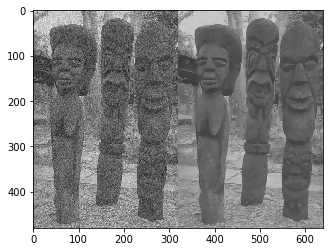

(320, 480)
(320, 480)
     Set68 : test010.png : 0.1181 second


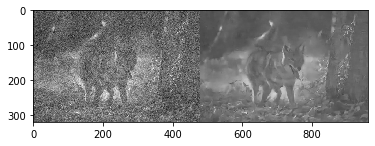

(320, 480)
(320, 480)
     Set68 : test007.png : 0.0089 second


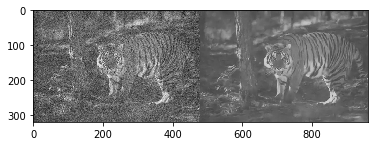

(480, 320)
(480, 320)
     Set68 : test002.png : 0.0092 second


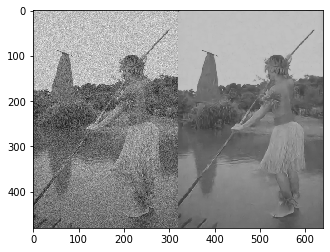

(320, 480)
(320, 480)
     Set68 : test005.png : 0.0097 second


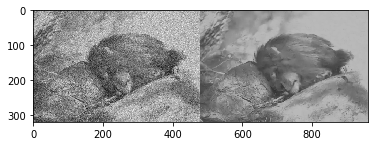

(320, 480)
(320, 480)
     Set68 : test008.png : 0.0093 second


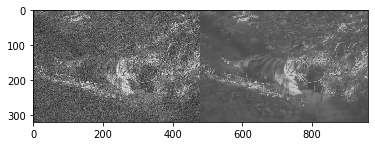

(480, 320)
(480, 320)
     Set68 : test003.png : 0.0093 second


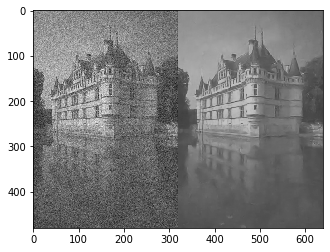

(320, 480)
(320, 480)
     Set68 : test004.png : 0.0093 second


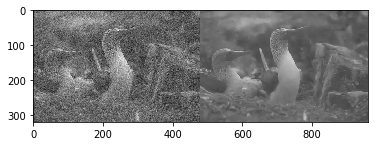

(320, 480)
(320, 480)
     Set68 : test006.png : 0.0094 second


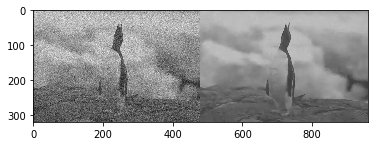

(320, 480)
(320, 480)
     Set68 : test009.png : 0.0091 second


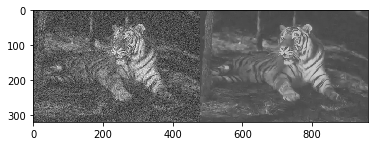

(320, 480)
(320, 480)
     Set68 : test011.png : 0.0097 second


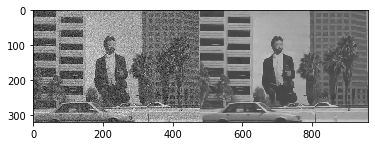

(320, 480)
(320, 480)
     Set68 : test013.png : 0.0093 second


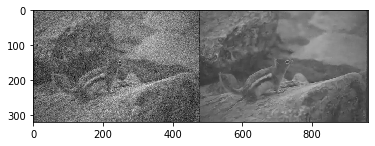

(320, 480)
(320, 480)
     Set68 : test012.png : 0.0094 second


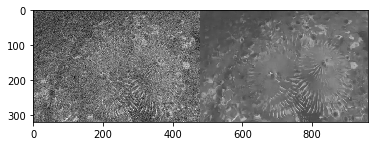

(320, 480)
(320, 480)
     Set68 : test017.png : 0.0093 second


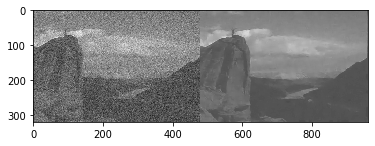

(320, 480)
(320, 480)
     Set68 : test014.png : 0.0096 second


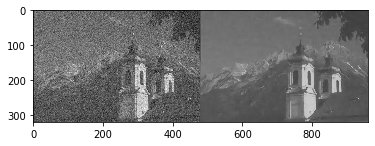

(320, 480)
(320, 480)
     Set68 : test019.png : 0.0096 second


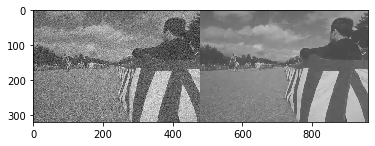

(320, 480)
(320, 480)
     Set68 : test015.png : 0.0095 second


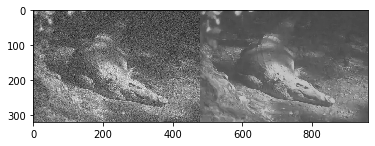

(320, 480)
(320, 480)
     Set68 : test016.png : 0.0092 second


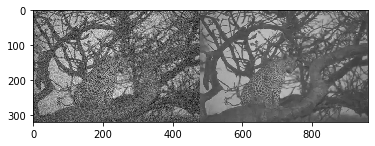

(320, 480)
(320, 480)
     Set68 : test018.png : 0.0100 second


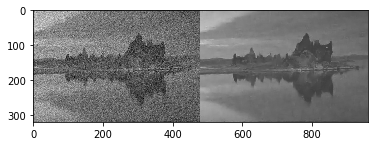

(320, 480)
(320, 480)
     Set68 : test020.png : 0.0096 second


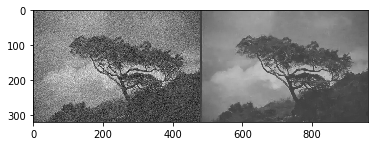

(480, 320)
(480, 320)
     Set68 : test021.png : 0.0100 second


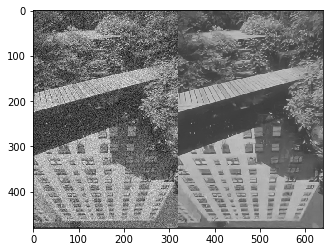

(320, 480)
(320, 480)
     Set68 : test024.png : 0.0094 second


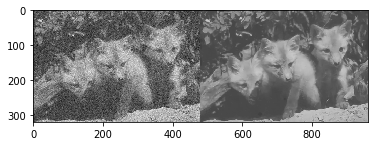

(320, 480)
(320, 480)
     Set68 : test023.png : 0.0095 second


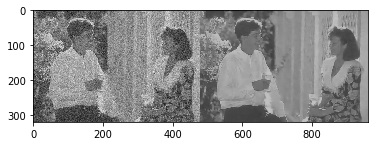

(480, 320)
(480, 320)
     Set68 : test029.png : 0.0093 second


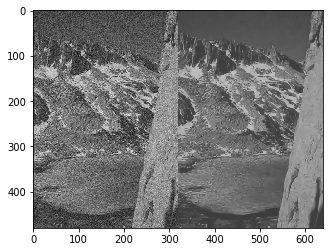

(320, 480)
(320, 480)
     Set68 : test025.png : 0.0097 second


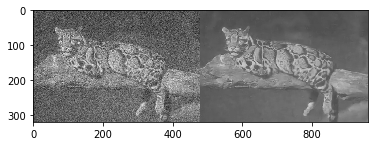

(320, 480)
(320, 480)
     Set68 : test022.png : 0.0091 second


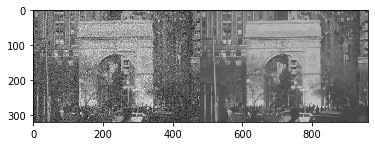

(320, 480)
(320, 480)
     Set68 : test028.png : 0.0098 second


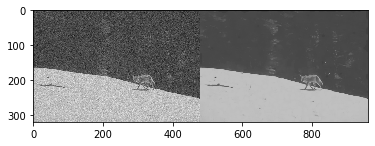

(320, 480)
(320, 480)
     Set68 : test026.png : 0.0095 second


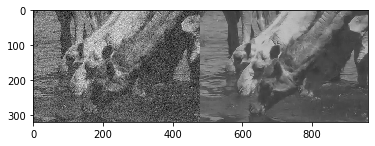

(320, 480)
(320, 480)
     Set68 : test027.png : 0.0098 second


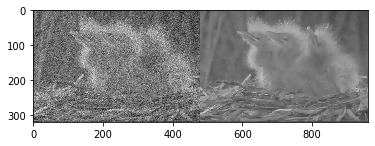

(320, 480)
(320, 480)
     Set68 : test030.png : 0.0096 second


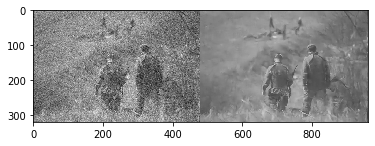

(480, 320)
(480, 320)
     Set68 : test031.png : 0.0112 second


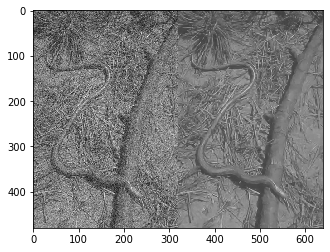

(320, 480)
(320, 480)
     Set68 : test033.png : 0.0093 second


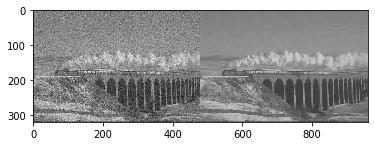

(480, 320)
(480, 320)
     Set68 : test039.png : 0.0091 second


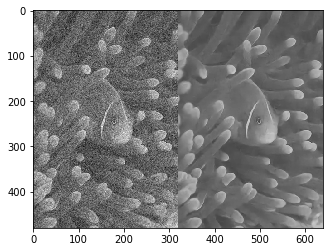

(320, 480)
(320, 480)
     Set68 : test032.png : 0.0092 second


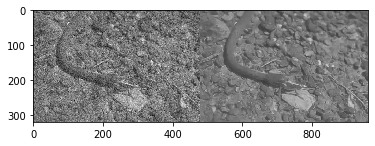

(480, 320)
(480, 320)
     Set68 : test038.png : 0.0093 second


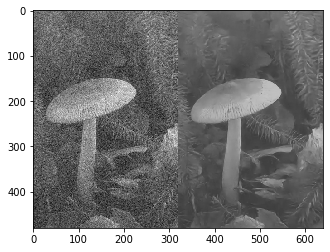

(320, 480)
(320, 480)
     Set68 : test037.png : 0.0094 second


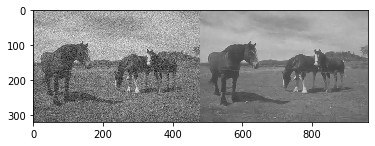

(480, 320)
(480, 320)
     Set68 : test034.png : 0.0096 second


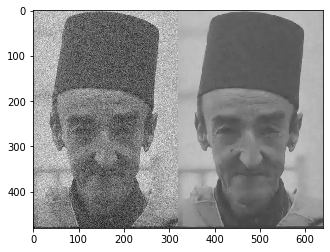

(320, 480)
(320, 480)
     Set68 : test036.png : 0.0095 second


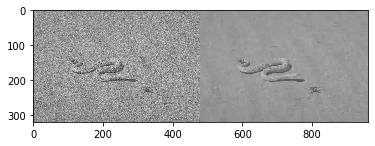

(320, 480)
(320, 480)
     Set68 : test035.png : 0.0096 second


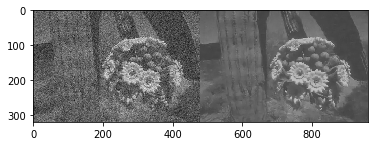

(320, 480)
(320, 480)
     Set68 : test040.png : 0.0095 second


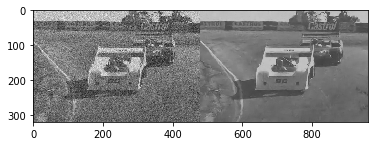

(320, 480)
(320, 480)
     Set68 : test041.png : 0.0094 second


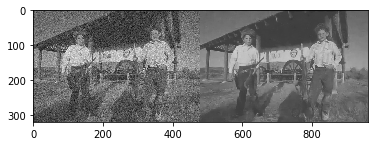

(320, 480)
(320, 480)
     Set68 : test042.png : 0.0096 second


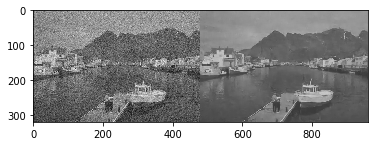

(480, 320)
(480, 320)
     Set68 : test045.png : 0.0094 second


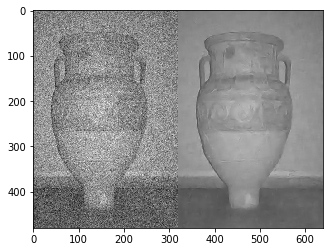

(320, 480)
(320, 480)
     Set68 : test044.png : 0.0102 second


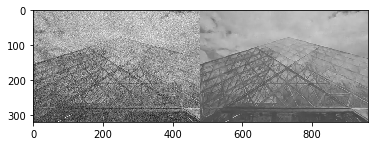

(320, 480)
(320, 480)
     Set68 : test047.png : 0.0095 second


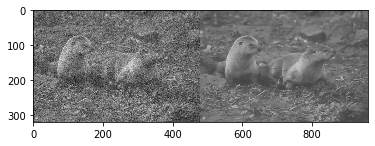

(320, 480)
(320, 480)
     Set68 : test050.png : 0.0096 second


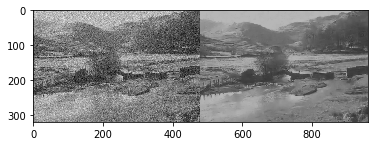

(320, 480)
(320, 480)
     Set68 : test046.png : 0.0096 second


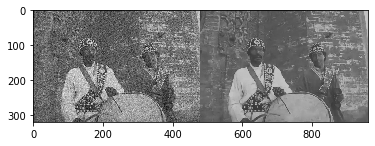

(320, 480)
(320, 480)
     Set68 : test043.png : 0.0097 second


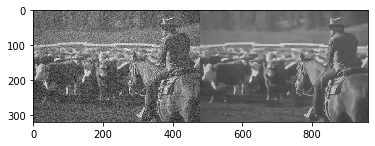

(320, 480)
(320, 480)
     Set68 : test048.png : 0.0102 second


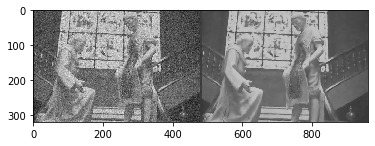

(320, 480)
(320, 480)
     Set68 : test049.png : 0.0099 second


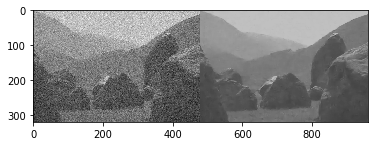

(320, 480)
(320, 480)
     Set68 : test051.png : 0.0096 second


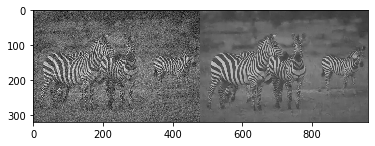

(480, 320)
(480, 320)
     Set68 : test055.png : 0.0097 second


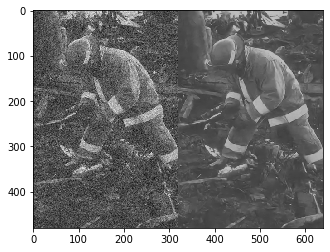

(320, 480)
(320, 480)
     Set68 : test059.png : 0.0100 second


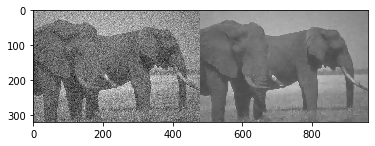

(320, 480)
(320, 480)
     Set68 : test052.png : 0.0097 second


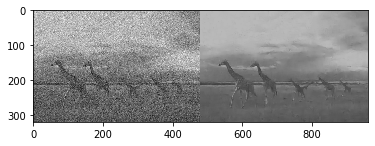

(320, 480)
(320, 480)
     Set68 : test060.png : 0.0098 second


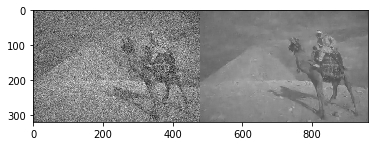

(320, 480)
(320, 480)
     Set68 : test057.png : 0.0092 second


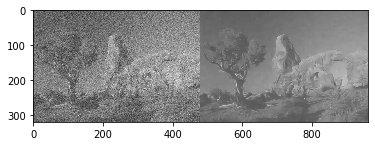

(320, 480)
(320, 480)
     Set68 : test053.png : 0.0100 second


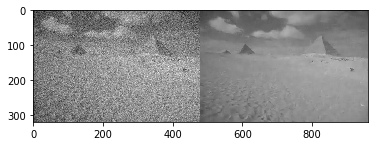

(320, 480)
(320, 480)
     Set68 : test058.png : 0.0095 second


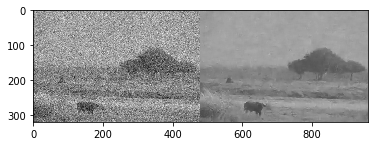

(320, 480)
(320, 480)
     Set68 : test056.png : 0.0097 second


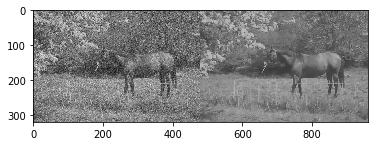

(480, 320)
(480, 320)
     Set68 : test054.png : 0.0093 second


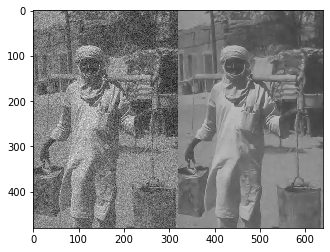

(320, 480)
(320, 480)
     Set68 : test066.png : 0.0093 second


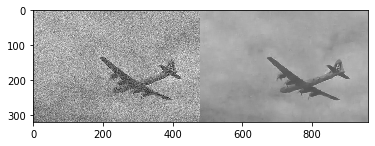

(320, 480)
(320, 480)
     Set68 : test063.png : 0.0094 second


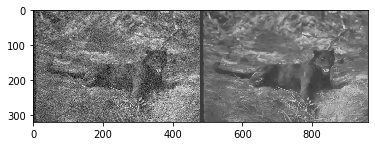

(320, 480)
(320, 480)
     Set68 : test068.png : 0.0095 second


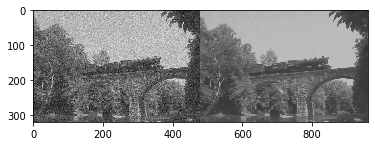

(480, 320)
(480, 320)
     Set68 : test062.png : 0.0093 second


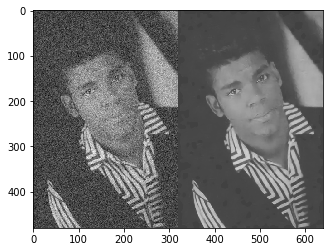

(480, 320)
(480, 320)
     Set68 : test067.png : 0.0094 second


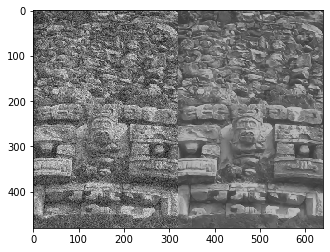

(480, 320)
(480, 320)
     Set68 : test064.png : 0.0096 second


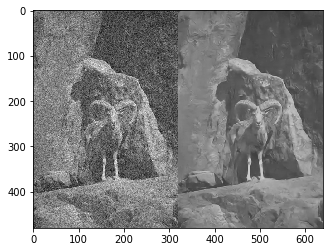

(320, 480)
(320, 480)
     Set68 : test065.png : 0.0094 second


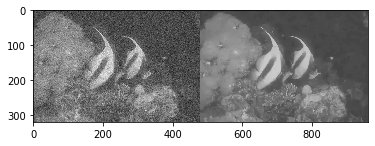

(320, 480)
(320, 480)
     Set68 : test061.png : 0.0093 second


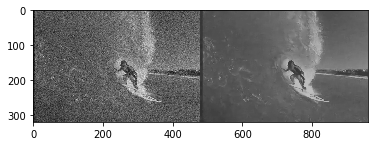

2019-11-15 10:38:12: Datset: Set68      
  PSNR = 27.53dB, SSIM = 0.8620
(256, 256)
(256, 256)
     Set12 :     01.png : 0.0797 second


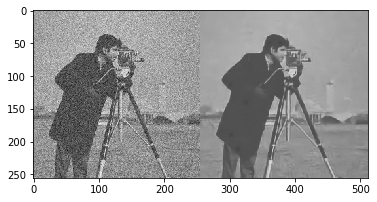

(256, 256)
(256, 256)
     Set12 :     02.png : 0.0050 second


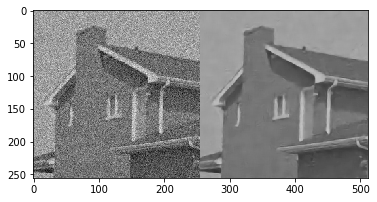

(256, 256)
(256, 256)
     Set12 :     03.png : 0.0047 second


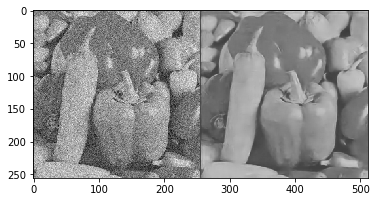

(256, 256)
(256, 256)
     Set12 :     04.png : 0.0048 second


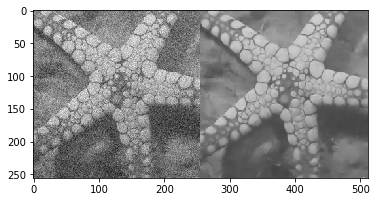

(256, 256)
(256, 256)
     Set12 :     05.png : 0.0049 second


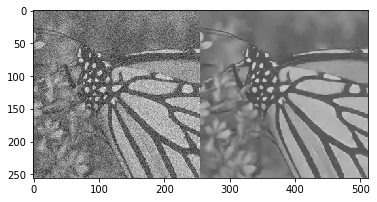

(256, 256)
(256, 256)
     Set12 :     06.png : 0.0047 second


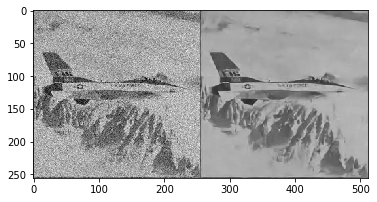

(256, 256)
(256, 256)
     Set12 :     07.png : 0.0048 second


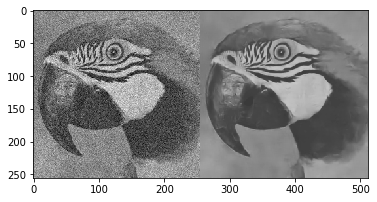

(512, 512)
(512, 512)
     Set12 :     08.png : 0.1397 second


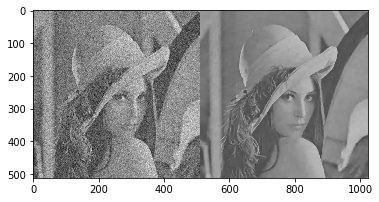

(512, 512)
(512, 512)
     Set12 :     09.png : 0.0149 second


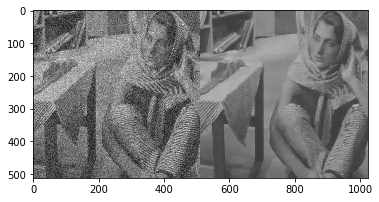

(512, 512)
(512, 512)
     Set12 :     10.png : 0.0134 second


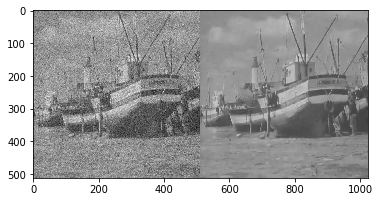

(512, 512)
(512, 512)
     Set12 :     11.png : 0.0138 second


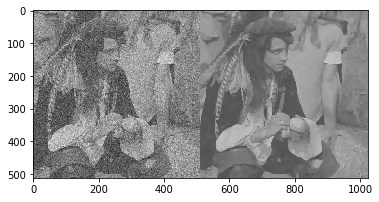

(512, 512)
(512, 512)
     Set12 :     12.png : 0.0146 second


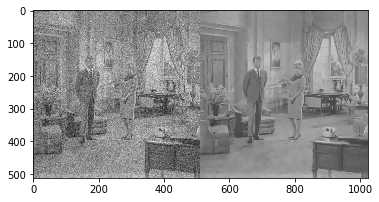

2019-11-15 10:38:25: Datset: Set12      
  PSNR = 28.35dB, SSIM = 0.8979


In [ ]:
if __name__ == '__main__':    
    
    args = parse_args()
    
    
    
    # =============================================================================
    # serialize model to JSON
    #model_json = model.to_json()
    #with open("model.json", "w") as json_file:
    #    json_file.write(model_json)
    #     # serialize weights to HDF5
    #model.save_weights("model.h5")
    #     print("Saved model")
    # =============================================================================

    if not os.path.exists(os.path.join(args.model_dir, args.model_name)):
        # load json and create model
        json_file = open(os.path.join(args.model_dir,'model.json'), 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        model.load_weights(os.path.join(args.model_dir,'model.h5'))
        log('load trained model on Train400 dataset by kai')
    else:
        model = load_model(os.path.join(args.model_dir, args.model_name),compile=False)
        log('load trained model')

    if not os.path.exists(args.result_dir):
        os.mkdir(args.result_dir)
        
    for set_cur in args.set_names:  
        
        if not os.path.exists(os.path.join(args.result_dir,set_cur)):
            os.mkdir(os.path.join(args.result_dir,set_cur))
        psnrs = []
        ssims = [] 
        
        # for im in os.listdir(os.path.join(args.set_dir,set_cur)): 
        #     if im.endswith(".jpg") or im.endswith(".bmp") or im.endswith(".png"):
        #         #x = np.array(Image.open(os.path.join(args.set_dir,set_cur,im)), dtype='float32') / 255.0
                
        #         x = np.array(imread(os.path.join(args.set_dir,set_cur,im)), dtype=np.float32) / 255.0
        #         np.random.seed(seed=0) # for reproducibility
        #         y = x + np.random.normal(0, args.sigma/255.0, x.shape) # Add Gaussian noise without clipping
        #         y = y.astype(np.float32)
        #         y_  = to_tensor(y)
        #         start_time = time.time()
        #         x_ = model.predict(y_) # inference
        #         #print(x_.shape)
        #         elapsed_time = time.time() - start_time
        #         print('%10s : %10s : %2.4f second'%(set_cur,im,elapsed_time))
        #         x_=from_tensor(x_)

        #         #plt.imshow(np.hstack((y,x_)))
        #         plt.imshow(y,cmap='gray')
        #         #plt.imshow(x_,cmap='gray')
        #         y= y[0:480,0:320]
        #         x= x[0:480,0:320]
        #         x_= x_[0:480,0:320]
                
        #         print(x.shape)
        #         print(y.shape)
        #         print(x_.shape)
              
        #         psnr_x_ = compare_psnr(x, x_)
        #         ssim_x_ = compare_ssim(x, x_)
        #         if args.save_result:
        #             name, ext = os.path.splitext(im)
        #             show(np.hstack((y,x_))) # show the image
        #             save_result(x_,path=os.path.join(args.result_dir,set_cur,name+'_dae'+ext)) # save the denoised image
        #         psnrs.append(psnr_x_)
        #         ssims.append(ssim_x_)

        for im in os.listdir(os.path.join(args.set_dir,set_cur)): 
            if im.endswith(".jpg") or im.endswith(".bmp") or im.endswith(".png"):
                #x = np.array(Image.open(os.path.join(args.set_dir,set_cur,im)), dtype='float32') / 255.0
                x = np.array(imread(os.path.join(args.set_dir,set_cur,im)), dtype=np.float32) / 255.0
                np.random.seed(seed=0) # for reproducibility
                if x.shape[0]%2==1 and x.shape[1]%2==1:
                   x= x[0:(x.shape[0] -1),0:(x.shape[1] -1)]
                y = x + np.random.normal(0, args.sigma/255.0, x.shape) # Add Gaussian noise without clipping
                print(x.shape)
                print(y.shape)
                y = y.astype(np.float32)
                y_  = to_tensor(y)
                start_time = time.time()
                x_ = model.predict(y_) # inference
                elapsed_time = time.time() - start_time
                print('%10s : %10s : %2.4f second'%(set_cur,im,elapsed_time))
                x_=from_tensor(x_)
                #if x.shape[0]%2 == 1 or x.shape[1]%2 == 1:
                #x= x[0:(x.shape[0] +0),0:(x.shape[1] +0)]
                #y= y[0:(y.shape[0] +0),0:(y.shape[1] +0)]
                #x_ = x_[0:(x_.shape[0]-3),0:(x_.shape[1]-3)]
                
                #print(x_.shape)                
                psnr_x_ = compare_psnr(x, x_)
                ssim_x_ = compare_ssim(x, x_)
                if args.save_result:
                    name, ext = os.path.splitext(im)
                    show(np.hstack((y,x_))) # show the image
                    save_result(x_,path=os.path.join(args.result_dir,set_cur,name+'_dae'+ext)) # save the denoised image
                psnrs.append(psnr_x_)
                ssims.append(ssim_x_)

        psnr_avg = np.mean(psnrs)
        ssim_avg = np.mean(ssims)
        psnrs.append(psnr_avg)
        ssims.append(ssim_avg)
        
        if args.save_result:
            save_result(np.hstack((psnrs,ssims)),path=os.path.join(args.result_dir,set_cur,'results.txt'))
            
        log('Datset: {0:10s} \n  PSNR = {1:2.2f}dB, SSIM = {2:1.4f}'.format(set_cur, psnr_avg, ssim_avg))

In [ ]:
psnr_avg

28.35144020691379

matplotlib.legend: WARNING No handles with labels found to put in legend.


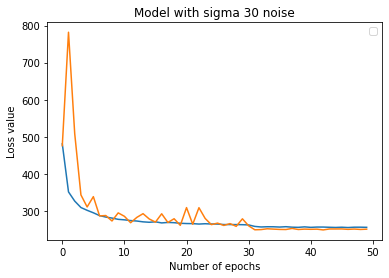

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
epoch = list(range(0,50))
df = pd.read_csv('/content/drive/My Drive/Project/models/Gaussian/Train400/dae_sigma30/log.csv')
plt.plot(epoch, df['loss'])
plt.plot(epoch, df['val_loss'])
plt.title('Model with sigma 30 noise')
plt.ylabel('Loss value')
plt.xlabel('Number of epochs')
plt.legend()
plt.show()
